In [1]:
import MDAnalysis as mda
import pandas as pd
import numpy as np
import time
import os

import warnings
# suppress some MDAnalysis warnings about PSF files
warnings.filterwarnings('ignore')

from MDAnalysis.analysis import rms, align
from matplotlib import pyplot as plt
# add path in order to import the module
import sys
# get the path to the root dir of the project e.g. '/Users/ferdinandtolkes/whk/code'
project_root_dir = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(project_root_dir)
from ground_state_md.utils import set_plotting_config, get_bin_number
from ground_state_md.setup_logger import setup_logger

logger = setup_logger("debug")
print("Using MDAnalysis version", mda.__version__)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

/loctmp/tof54964/miniconda3/envs/schnet/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using MDAnalysis version 2.9.0


In [2]:
# Set necessary paths
n_steps = 1000
dt = 0.5  # time step in fs
target_sim = f"md_sim_steps_{n_steps}_time_step_{dt}_seed_42"
run_dir = os.path.join(project_root_dir, "ground_state_md/training_and_inference/runs")
path_to_nn_xyz = f"{run_dir}/angstrom_kcal_per_mol_fs/MOTOR_MD_XTB/T300_1/epochs_1_bs_100_lr_0.0001_flw_0.99_elw_0.01_seed_42/{target_sim}"
path_to_xtb_xyz = f"{run_dir}/xtb_md_simulations//MOTOR_MD_XTB/T300_1/{target_sim}"

In [3]:
# load the trajectories
# Note: xyz files from ASE use units of eV, Angstroms and atomic masses
u_xtb = mda.Universe(f"{path_to_xtb_xyz}/xtb_traj.xyz", format='XYZ')
u_nn = mda.Universe(f"{path_to_nn_xyz}/nn_traj.xyz", format='XYZ')
logger.debug(f"Loaded trajectories from {path_to_xtb_xyz} and {path_to_nn_xyz}")
logger.debug(f"Number of frames in xtb trajectory: {len(u_xtb.trajectory)}")
logger.debug(f"Number of frames in nn trajectory: {len(u_nn.trajectory)}")

INFO:MDAnalysis.core.universe:attribute types has been guessed successfully.
INFO:MDAnalysis.core.universe:attribute masses has been guessed successfully.
INFO:MDAnalysis.core.universe:attribute types has been guessed successfully.
INFO:MDAnalysis.core.universe:attribute masses has been guessed successfully.
2025-08-20 12:55:44,749 - __main__ - DEBUG - Loaded trajectories from /home/tof54964/whk/code/ground_state_md/training_and_inference/runs/xtb_md_simulations//MOTOR_MD_XTB/T300_1/md_sim_steps_1000_time_step_0.5_seed_42 and /home/tof54964/whk/code/ground_state_md/training_and_inference/runs/angstrom_kcal_per_mol_fs/MOTOR_MD_XTB/T300_1/epochs_1_bs_100_lr_0.0001_flw_0.99_elw_0.01_seed_42/md_sim_steps_1000_time_step_0.5_seed_42
2025-08-20 12:55:44,770 - __main__ - DEBUG - Number of frames in xtb trajectory: 1001
2025-08-20 12:55:44,782 - __main__ - DEBUG - Number of frames in nn trajectory: 1001


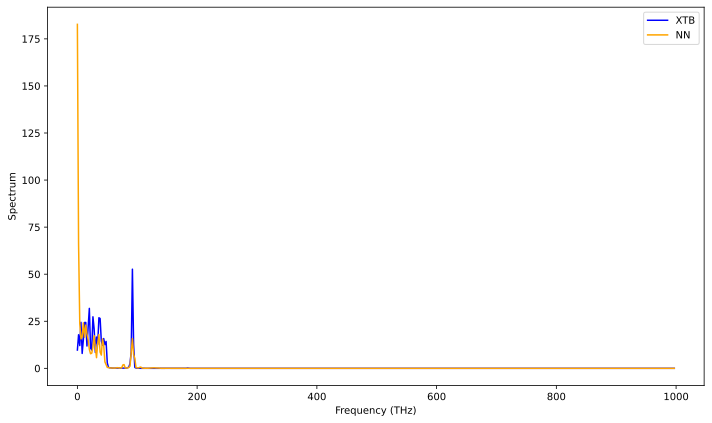

Pearson correlation coefficient between XTB and NN DOS: 0.4066


In [4]:
from ase import io
from fastatomstruct import vibrational_dos
from scipy.stats import pearsonr

atoms_xtb = io.read(f"{path_to_xtb_xyz}/xtb_traj.traj", index=':')
atoms_nn = io.read(f"{path_to_nn_xyz}/nn_traj.traj", index=':')

freqs_xtb, dos_xtb = vibrational_dos(atoms_xtb, timestep=dt) # frequency unit [1/dt] 1/fs = PHz
freqs_nn, dos_nn = vibrational_dos(atoms_nn, timestep=dt)

n_samples_dos = 500
freqs_xtb, dos_xtb = freqs_xtb[:n_samples_dos], dos_xtb[:n_samples_dos]
freqs_nn, dos_nn = freqs_nn[:n_samples_dos], dos_nn[:n_samples_dos]

freqs_xtb *= 1000 # convert from PHz to THz
freqs_nn *= 1000 # convert to THz

# plotting
#set_plotting_config(12, 8/4, 0.5) # for creating nice plots for latex
plt.figure(figsize=(10, 6))
plt.plot(freqs_xtb, dos_xtb, label='XTB', color='blue')
plt.plot(freqs_nn, dos_nn, label='NN', color='orange')
plt.xlabel('Frequency (THz)')
plt.ylabel('Spectrum')
# plt.title('Vibrational Density of States (VDOS)')
plt.legend()
plt.tight_layout()
# plt.savefig('power_spectrum.png', dpi=300)
plt.show()

# compute correlation coefficient
corr_coef = pearsonr(dos_xtb, dos_nn)[0]
print(f"Pearson correlation coefficient between XTB and NN DOS: {corr_coef:.4f}")

In [5]:
def check_atom_names(u_xtb: mda.Universe, u_nn: mda.Universe):
    """
    Check if all the atom names in the two universes are the same.
    Args:
        u_xtb (mda.Universe): Universe object for the XTB trajectory.
        u_nn (mda.Universe): Universe object for the NN trajectory.
    Raises:
        ValueError: If the atom names do not match.
    """
    if not np.array_equal(u_xtb.atoms.names, u_nn.atoms.names):
        raise ValueError("Atom names in the two universes do not match.")
    else:
        logger.info("Atom names match.")

def check_atom_masses(u_xtb: mda.Universe, u_nn: mda.Universe):
    """
    Check if all the atom masses in the two universes are the same.
    Args:
        u_xtb (mda.Universe): Universe object for the XTB trajectory.
        u_nn (mda.Universe): Universe object for the NN trajectory.
    Raises:
        ValueError: If the atom masses do not match.
    """
    if not np.allclose(u_xtb.atoms.masses, u_nn.atoms.masses):
        raise ValueError("Atom masses in the two universes do not match.")
    else:
        logger.info("Atom masses match.")

check_atom_names(u_xtb, u_nn)
check_atom_masses(u_xtb, u_nn)

2025-08-20 12:55:53,698 - __main__ - INFO - Atom names match.
2025-08-20 12:55:53,699 - __main__ - INFO - Atom masses match.


In [6]:
def get_radius_of_gyration(u_xtb: mda.Universe, u_nn: mda.Universe) -> tuple:
    """
    Calculate the radius of gyration for both universes.
    Args:
        u_xtb (mda.Universe): Universe object for the XTB trajectory.
        u_nn (mda.Universe): Universe object for the NN trajectory.
    Returns:
        tuple: A tuple containing the radius of gyration DataFrames for XTB and NN.
    """
    rgyr_xtb = []
    rgyr_nn = []
    sim_times = []
    
    for ts in u_xtb.trajectory:
        sim_times.append(ts.time)
        rgyr_xtb.append(u_xtb.atoms.radius_of_gyration())
    
    for ts in u_nn.trajectory:
        rgyr_nn.append(u_nn.atoms.radius_of_gyration())

    rgyr_xtb_df = pd.DataFrame(rgyr_xtb, columns=['Radius of gyration (A)'], index=sim_times)
    rgyr_xtb_df.index.name = 'Time (fs)'

    rgyr_nn_df = pd.DataFrame(rgyr_nn, columns=['Radius of gyration (A)'], index=sim_times)
    rgyr_nn_df.index.name = 'Time (fs)'

    return rgyr_xtb_df, rgyr_nn_df

rgyr_xtb_df, rgyr_nn_df = get_radius_of_gyration(u_xtb, u_nn)
logger.debug(f"First 5 rows of XTB radius of gyration:\n{rgyr_xtb_df.head()}")
logger.debug(f"First 5 rows of NN radius of gyration:\n{rgyr_nn_df.head()}")

2025-08-20 12:55:54,707 - __main__ - DEBUG - First 5 rows of XTB radius of gyration:
           Radius of gyration (A)
Time (fs)                        
0.0                      3.532178
1.0                      3.532260
2.0                      3.532349
3.0                      3.532444
4.0                      3.532542
2025-08-20 12:55:54,707 - __main__ - DEBUG - First 5 rows of NN radius of gyration:
           Radius of gyration (A)
Time (fs)                        
0.0                      3.532178
1.0                      3.532256
2.0                      3.532334
3.0                      3.532408
4.0                      3.532477


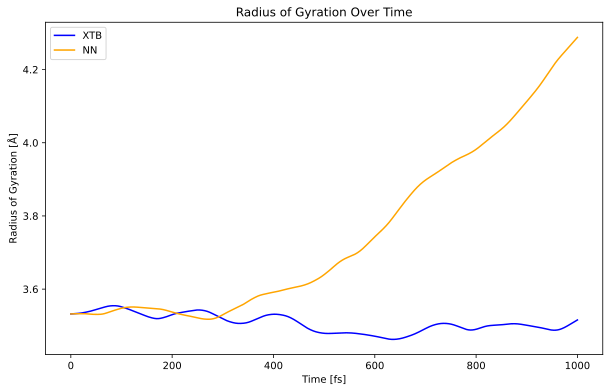

In [7]:
# plotting the radius of gyration for both XTB and NN over time
#set_plotting_config(10, 8/4, 1) # for creating nice plots for latex
plt.figure(figsize=(10, 6))
plt.plot(rgyr_xtb_df.index, rgyr_xtb_df['Radius of gyration (A)'], label='XTB', color='blue')
plt.plot(rgyr_nn_df.index, rgyr_nn_df['Radius of gyration (A)'], label='NN', color='orange')
plt.xlabel('Time [fs]')
plt.ylabel('Radius of Gyration [$\mathrm{\AA}$]')
plt.legend()
plt.title('Radius of Gyration Over Time')
plt.show()

2025-08-20 12:55:56,288 - ground_state_md.utils - DEBUG - Calculated number of bins: 10 for data with shape (1001,)
2025-08-20 12:55:56,289 - ground_state_md.utils - DEBUG - Calculated number of bins: 9 for data with shape (1001,)


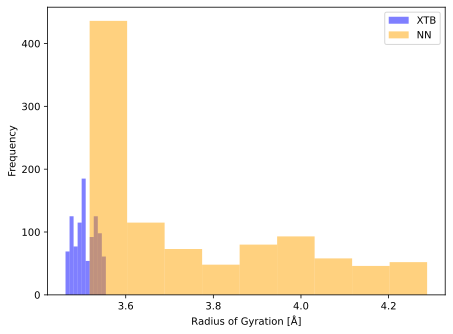

In [8]:
# plotting histograms of the radius of gyration for both XTB and NN
#set_plotting_config(16, 4/4, 0.5) # for creating nice plots for latex
n_bins_xtb = get_bin_number(rgyr_xtb_df['Radius of gyration (A)'].values)
n_bins_nn = get_bin_number(rgyr_nn_df['Radius of gyration (A)'].values)

#plt.figure(figsize=(10, 6))
plt.hist(rgyr_xtb_df['Radius of gyration (A)'], bins=n_bins_xtb, alpha=0.5, label='XTB', color='blue')
plt.hist(rgyr_nn_df['Radius of gyration (A)'], bins=n_bins_nn, alpha=0.5, label='NN', color='orange')
plt.xlabel('Radius of Gyration [$\mathrm{\AA}$]')
plt.ylabel('Frequency')
plt.legend()
# plt.title('Histogram of Radius of Gyration')
plt.tight_layout()
# plt.savefig('radius_of_gyration_histogram.png', dpi=300)
plt.show()

In [9]:
def check_reference_frames_match(u_xtb: mda.Universe, u_nn: mda.Universe) -> np.ndarray:
    """
    Ensure the initial frames of both trajectories match.
    Args:
        u_xtb (mda.Universe): Universe object for the XTB trajectory.
        u_nn (mda.Universe): Universe object for the NN trajectory.
    Returns:
        np.ndarray: The reference frame positions from the XTB trajectory.
    Raises:
        ValueError: If the reference frames of the two trajectories do not match.
    """
    ref_xtb = u_xtb.trajectory[0].positions.copy()
    ref_nn = u_nn.trajectory[0].positions
    # check if the reference frames are close enough to be considered equal
    if not np.allclose(ref_xtb, ref_nn, atol=1e-5):
        raise ValueError("Reference frames of XTB and NN trajectories do not match.")
    # if not np.array_equal(ref_xtb, ref_nn):
    #     raise ValueError("Reference frames of XTB and NN trajectories do not match.")
    return ref_xtb


def compute_rmsd_trajectories(u_xtb: mda.Universe, u_nn: mda.Universe) -> pd.DataFrame:
    """
    Compute RMSD values for each timestep of two trajectories.
    Args:
        u_xtb (mda.Universe): Universe object for the XTB trajectory.
        u_nn (mda.Universe): Universe object for the NN trajectory.
    Returns:
        pd.DataFrame: DataFrame containing RMSD values for XTB, NN, and their comparison.
    Raises:
        ValueError: If the time steps of the two trajectories do not match.
        ValueError: If the reference frames of the two trajectories do not match.
    """
    reference_frame = check_reference_frames_match(u_xtb, u_nn)

    rmsd_comparison = []
    rmsd_xtb = []
    rmsd_nn = []
    sim_times = []

    for xtb_ts, nn_ts in zip(u_xtb.trajectory, u_nn.trajectory):
        if xtb_ts.time != nn_ts.time:
            raise ValueError("Time mismatch between XTB and NN trajectories.")

        rmsd_comparison.append(rms.rmsd(xtb_ts.positions, nn_ts.positions))
        rmsd_xtb.append(rms.rmsd(xtb_ts.positions, reference_frame))
        rmsd_nn.append(rms.rmsd(nn_ts.positions, reference_frame))
        sim_times.append(xtb_ts.time)

    return pd.DataFrame({
        'RMSD XTB (A)': rmsd_xtb,
        'RMSD NN (A)': rmsd_nn,
        'RMSD Comparison (A)': rmsd_comparison
    }, index=pd.Index(sim_times, name='Time (fs)'))


start = time.time()
rmsd_analysis = compute_rmsd_trajectories(u_xtb, u_nn)
logger.info(f"RMSD analysis completed in {time.time() - start:.2f} seconds.")
logger.debug(f"First 5 rows of RMSD analysis:\n{rmsd_analysis.head()}")



2025-08-20 12:55:57,249 - __main__ - INFO - RMSD analysis completed in 0.09 seconds.
2025-08-20 12:55:57,250 - __main__ - DEBUG - First 5 rows of RMSD analysis:
           RMSD XTB (A)  RMSD NN (A)  RMSD Comparison (A)
Time (fs)                                                
0.0            0.000000     0.000003             0.000003
1.0            0.008407     0.008443             0.000216
2.0            0.016248     0.016404             0.000878
3.0            0.023487     0.023846             0.001987
4.0            0.030184     0.030803             0.003526


<Figure size 1000x600 with 0 Axes>

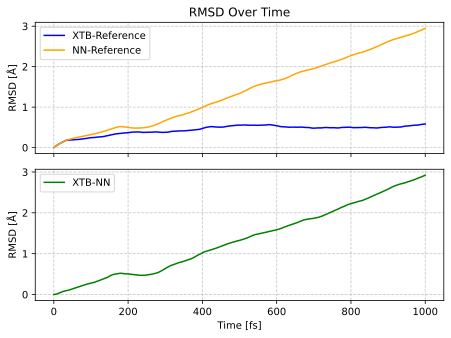

In [10]:
# Plotting the RMSD over time with grid lines
#set_plotting_config(10, 4/4, 1) # for creating nice plots for latex
plt.figure(figsize=(10, 6))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
# Top plot: XTB-Reference and NN-Reference
ax1.plot(rmsd_analysis.index, rmsd_analysis['RMSD XTB (A)'], label='XTB-Reference', color='blue')
ax1.plot(rmsd_analysis.index, rmsd_analysis['RMSD NN (A)'], label='NN-Reference', color='orange')
ax1.set_ylabel(r'RMSD [$\mathrm{\AA}$]')
ax1.set_title('RMSD Over Time')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.7)

# Bottom plot: XTB-NN
ax2.plot(rmsd_analysis.index, rmsd_analysis['RMSD Comparison (A)'], label='XTB-NN', color='green')
ax2.set_xlabel('Time [fs]')
ax2.set_ylabel(r'RMSD [$\mathrm{\AA}$]')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [11]:
def compute_rmsf(universe: mda.Universe, ref_frame: int = 0) -> np.ndarray:
    """
    Compute the root mean square fluctuation (RMSF) of the atoms in a given universe.
    Args:
        universe (mda.Universe): The MDAnalysis universe containing the trajectory.
        ref_frame (int): The index of the reference frame to align against.
    Returns:
        np.ndarray: The RMSF values for each atom.
    """
    if ref_frame < 0 or ref_frame >= len(universe.trajectory):
        raise ValueError(f"Reference frame index {ref_frame} is out of bounds for the trajectory with {len(universe.trajectory)} frames.")
    # Compute the average structure as reference
    avg = align.AverageStructure(universe, universe, ref_frame=ref_frame).run()
    reference = avg.results.universe
    # Align the trajectory to the reference frame
    align.AlignTraj(universe, reference, in_memory=True).run()
    results = rms.RMSF(universe.atoms).run()
    logger.debug(f"RMSF computed for {len(universe.atoms)} atoms over {len(universe.trajectory)} frames.")
    return results.rmsf

# Compute RMSF for both XTB and NN trajectories
rmsf_xtb = compute_rmsf(u_xtb, ref_frame=0)
rmsf_nn = compute_rmsf(u_nn, ref_frame=0)

INFO:MDAnalysis.analysis.align:Moved mobile trajectory to in-memory representation
INFO:MDAnalysis.analysis.base:Choosing frames to analyze
INFO:MDAnalysis.analysis.base:Starting preparation
INFO:MDAnalysis.analysis.base:Finishing up
2025-08-20 12:55:59,457 - __main__ - DEBUG - RMSF computed for 48 atoms over 1001 frames.
INFO:MDAnalysis.analysis.align:Moved mobile trajectory to in-memory representation
INFO:MDAnalysis.analysis.base:Choosing frames to analyze
INFO:MDAnalysis.analysis.base:Starting preparation
INFO:MDAnalysis.analysis.base:Finishing up
2025-08-20 12:55:59,623 - __main__ - DEBUG - RMSF computed for 48 atoms over 1001 frames.


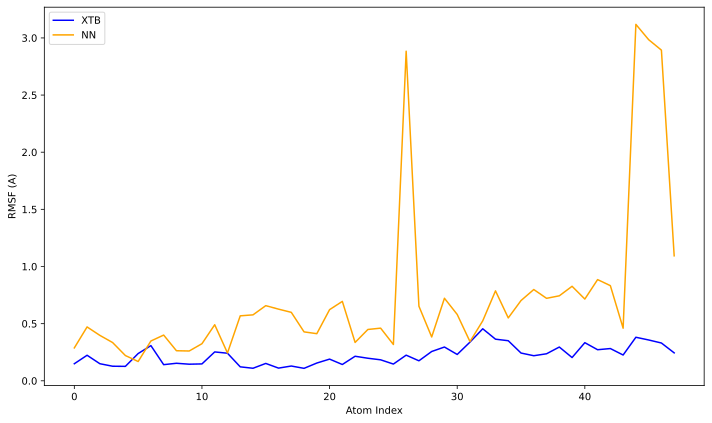

Pearson correlation coefficient between XTB and NN RMSF: 0.4277
u_xtb.atoms.names: ['O' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C'
 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H'
 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H']


In [12]:
# plot per-atom fluctuations for XTB
#set_plotting_config(16, 4/4, 0.5) # for creating nice plots for latex
plt.figure(figsize=(10, 6))
plt.plot(u_xtb.atoms.indices, rmsf_xtb, label='XTB', color='blue')
plt.plot(u_nn.atoms.indices, rmsf_nn, label='NN', color='orange')
plt.xlabel('Atom Index')
plt.ylabel('RMSF (A)')
plt.legend()
corr_rmsf = pearsonr(rmsf_xtb, rmsf_nn)[0]
#plt.title(f'Per-Atom Fluctuations (RMSF), Pearson r: {corr_rmsf:.4f}')
plt.tight_layout()
# plt.savefig('per_atom_fluctuations_rmsf.png', dpi=300)
plt.show()
print(f"Pearson correlation coefficient between XTB and NN RMSF: {corr_rmsf:.4f}")
print(f"u_xtb.atoms.names: {u_xtb.atoms.names}")

In [13]:
# Compute all interatomic distances over the trajectory and compare distributions
def compute_interatomic_distances(universe: mda.Universe) -> np.ndarray:
    """
    Compute interatomic distances for all frames in the trajectory.
    Args:
        universe (mda.Universe): The MDAnalysis universe object containing the trajectory.
    Returns:
        np.ndarray: An array of interatomic distances for each frame.
    """
    distances = []
    for ts in universe.trajectory:
        dist = mda.lib.distances.distance_array(
            ts.positions, ts.positions)
        distances.append(dist[np.triu_indices_from(dist, k=1)])
    np_distances = np.array(distances)
    logger.debug(f"Computed interatomic distances: {np_distances.shape}")
    return np_distances

distances_xtb = compute_interatomic_distances(u_xtb)
distances_nn = compute_interatomic_distances(u_nn)

dists_xtb_flatten = distances_xtb.flatten()
dists_nn_flatten = distances_nn.flatten()

2025-08-20 12:56:04,299 - __main__ - DEBUG - Computed interatomic distances: (1001, 1128)
2025-08-20 12:56:04,319 - __main__ - DEBUG - Computed interatomic distances: (1001, 1128)


2025-08-20 12:56:05,494 - ground_state_md.utils - DEBUG - Calculated number of bins: 152 for data with shape (1129128,)
2025-08-20 12:56:05,501 - ground_state_md.utils - DEBUG - Calculated number of bins: 193 for data with shape (1129128,)


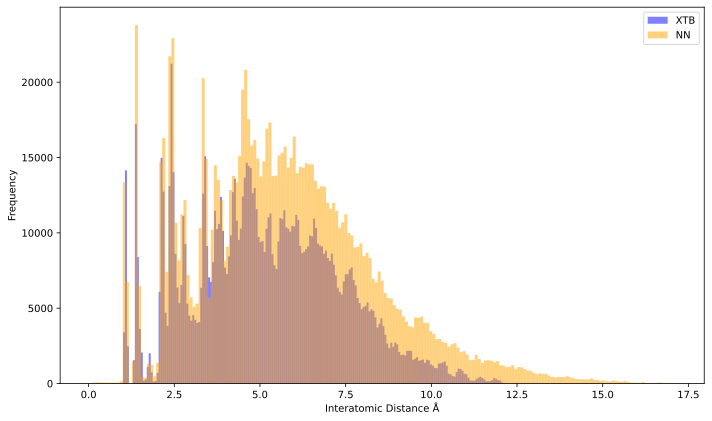

In [14]:
# plot and compare the distributions of interatomic distances
#set_plotting_config(12, 8/4, 0.5) # for creating nice plots for latex
plt.figure(figsize=(10, 6))
n_bins_xtb = get_bin_number(dists_xtb_flatten)
n_bins_nn = get_bin_number(dists_nn_flatten)
n_bins = max(n_bins_xtb, n_bins_nn)

plt.hist(dists_xtb_flatten, bins=n_bins, alpha=0.5, label='XTB', color='blue')
plt.hist(dists_nn_flatten, bins=n_bins, alpha=0.5, label='NN', color='orange')
plt.xlabel('Interatomic Distance $\mathrm{\AA}$')
plt.ylabel('Frequency')
plt.legend()
#plt.title('Distribution of Interatomic Distances')
plt.tight_layout()
# plt.savefig('interatomic_distances_distribution.png', dpi=300)
plt.show()